# Task : 2-1

Researchers have measured a bivariate timeseries, but the equipment was unreliable so the data has gaps as well as noise. The data can be found in [data.csv](https://gist.github.com/tmramalho/51733432c88e2b834dbd70353849f887)

In this exercise, we want to train an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) to regress the full observed trajectory from the measured data. Formally, the MLP will be used to approximate the function $f:\mathbb{R} \rightarrow \mathbb{R}^2 ; f(t) = (x(t), y(t))$. In other words, the model takes the current time as an input, and predicts the values of `x` and `y` at that time based only on the measured data.

Your task is to define the data loader, the MLP model and the loss function to complete this task successfully. For this problem you will need to use a regression loss, not a classification loss.

Successful training should result in a data interpolation similar to the below:
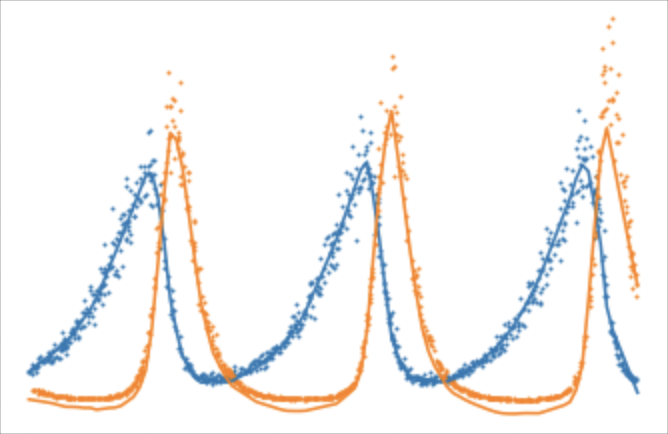

### Concept - ** for understanding only **
A bivariate time series is a time series that consists of two variables (or signals) measured over time. In simple terms: It's like tracking two things (e.g., temperature and humidity, or position in x and y) at the same time across many time steps.

| Time | x(t) (variable 1) | y(t) (variable 2) |
| ---- | ----------------- | ----------------- |
| 0.0  | 1.2               | 4.5               |
| 0.1  | 1.3               | 4.6               |
| ...  | ...               | ...               |

* Task: basically Data Interpolation (Interpolation is the process of estimating an unknown value within a sequence of known values. Like here we we train model when 0≤t≤20 and also predict x(t) and y(t) when 0≤t≤20)


### Imports

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler

### Data Pre-Processing

In [13]:
# Load Dataset
dataset = '/content/sample_data/data.csv' # CSV File Dir
df = pd.read_csv(dataset)                 # Read CSV

#### Data Analysis & Cleaning
- data.csv has 2000 samples. All t-vals are ok
- t-vals are from 0 to 19.99 with an interval of 0.01 between two t-vals
- Given dataset 'data.csv' has missing values replaced as '-' hyphen on either one of x/y cols or on both x & y cols
- Data Cleaning:- Remove rows having '-' hyphen as value on either one of x or y cols or on both x & y cols

In [14]:
# Data Analysis - Before cleaning
print(df.count(), "\n") # count samples
print(df.head(5))       # check sample

t    2000
x    2000
y    2000
dtype: int64 

      t                   x                   y
0  0.00                   -  0.5759052335487023
1  0.01                   -                   -
2  0.02  1.1159124144549086                   -
3  0.03                   -                   -
4  0.04  1.0054825084650338  0.4775267298487888


In [15]:
# Removing rows with '-' as value
df_cleaned = df[~(df['x'].astype(str).str.contains('-') | df['y'].astype(str).str.contains('-'))].copy()

# Making Sure all columns values are numeric
df_cleaned.loc[:, ['t', 'x', 'y']] = df_cleaned[['t', 'x', 'y']].apply(pd.to_numeric, errors='coerce') # coerce = NaN

In [16]:
# Data Analysis - After cleaning
print(df_cleaned.count())       # count samples
print(df_cleaned.head(5))       # check sample
print(type(df_cleaned['x'][4])) # checks if individual val is numeric

t    327
x    327
y    327
dtype: int64
       t         x         y
4   0.04  1.005483  0.477527
6   0.06  1.101832  0.460175
13  0.13  1.020803  0.376706
18  0.18  1.165619  0.345918
30  0.30  1.161122  0.397953
<class 'float'>


***** Note:- Only 327 Data remains after cleaning, this would be training set***

#### Data Visualization

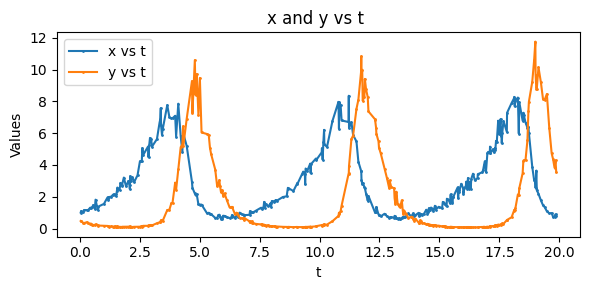

In [17]:
# Plotting Cleaned Dataset of 327 values only | Plotting x against t , y against t
plt.figure(figsize=(6, 3))
plt.plot(df_cleaned['t'], df_cleaned['x'], label='x vs t', marker='.', markersize=2)
plt.plot(df_cleaned['t'], df_cleaned['y'], label='y vs t', marker='.', markersize=2)

plt.xlabel('t')
plt.ylabel('Values')
plt.title('x and y vs t ')
plt.legend()
plt.tight_layout()
plt.show()

"""'
**My Note:-
- Original Dataset is plotted after cleaning
- Only 327 Data plotted
- Curve is not smooth and fluctuating means dataset data.csv is full of noise / missing vals
"""
print()

### Model : MLP-Regression

#### MLP Model Architecutre

In [18]:
class Net(nn.Module):
    """ Model to regress 2D time series values (x & y) given scalar input (t)"""

    # MLP Model Architecture
    def __init__(self):
        super(Net, self).__init__()
        # Define the MLP architecture
        self.fc1 = nn.Linear(1, 64)     # Input t is 1, scalar (time), output to 64 units os (1,64)
        self.fc2 = nn.Linear(64, 128)   # Hidden layer with 128 units
        self.fc3 = nn.Linear(128, 256)  # Hidden layer with 256 units
        self.fc4 = nn.Linear(256, 2)    # Output 2 values (x(t), y(t))
        self.relu = nn.ReLU()           # Act Func : ReLU

    # Forward Prop
    def forward(self, x):
        # Define forward pass through the network when input 'x' is passed to the model
        x = self.relu(self.fc1(x))   # First hidden layer. fc1(x), here x = t = input scalar (1D)
        x = self.relu(self.fc2(x))   # Second hidden layer. fc2(x), here x = output of fc1 / x = (64,)
        x = self.relu(self.fc3(x))   # third hidden layer. fc3(x), here x = output of fc2 / x = (128,)
        x = self.fc4(x)              # Output layer (2D values). fc4(x), here x output of fc3 / x = (256,)
        return x                     # here x = (2,) tensor

#### Time-Series Dataset

In [19]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data_frame):
        # Load the data
        self.data = data_frame

        # Extract time column (t) and target columns (x, y)
        self.time = self.data['t'].values           # Feature 't'
        self.target = self.data[['x', 'y']].values  # Targets are x(t), y(t)

        # Convert to numeric type (float32 or float64)
        self.time = self.time.astype(np.float32)      # Ensure time is float32
        self.target = self.target.astype(np.float32)  # Ensure x, y targets are float32

    def __len__(self):
        # Return the number of samples
        return len(self.time)

    def __getitem__(self, idx):
        # Get the time and target values for a specific index & convert to a PyTorch tensor.
        time = torch.tensor(self.time[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        return time, target

#### Data-Loader & Loss-Func

In [20]:
# Load the dataset and define the DataLoader
dataset = TimeSeriesDataset(df_cleaned) # instead of passing raw 'data.csv', passed cleaned dataframe
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2) # 32

# Define the loss function (MSE for Regression)
def loss_fn(outputs, labels): # (ŷ,y)
    return nn.MSELoss()(outputs, labels)

#### Init Model & Optimizer

In [21]:
# Initialize the model
net = Net()

# Choose an optimizer (Adam is a good choice for most tasks)
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [22]:
# ** for debugging purposes only **
# print(f"Total batches in DataLoader: {len(trainloader)}")
# for i, data in enumerate(trainloader, 0):
#   print(i % 20)

#### Model Training

In [23]:
for epoch in range(2400): # trained twice for better results
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0): # data = each minibatch = 32 samples
      inputs, labels = data

      # Ensure inputs are of shape (batch_size, 1) for t
      inputs = inputs.view(-1, 1)  # Flatten the inputs to match the expected shape

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs) # Pass training data / input (t) to model net(), returns predicted x(t), y(t) in outputs
      loss = loss_fn(outputs, labels) # calc loss (ŷ-predicted, y-actual)
      loss.backward() # computes gradients
      optimizer.step() # updates gradients

      # print statistics
      running_loss += loss.item()
      if i % 20 == i:    # print every 20 mini-batches
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 20))
          running_loss = 0.0

print('Finished Training')

Streaming output truncated to the last 5000 lines.
[1946,     7] loss: 0.023
[1946,     8] loss: 0.011
[1946,     9] loss: 0.014
[1946,    10] loss: 0.010
[1946,    11] loss: 0.007
[1947,     1] loss: 0.011
[1947,     2] loss: 0.010
[1947,     3] loss: 0.025
[1947,     4] loss: 0.013
[1947,     5] loss: 0.008
[1947,     6] loss: 0.012
[1947,     7] loss: 0.017
[1947,     8] loss: 0.006
[1947,     9] loss: 0.013
[1947,    10] loss: 0.007
[1947,    11] loss: 0.011
[1948,     1] loss: 0.007
[1948,     2] loss: 0.019
[1948,     3] loss: 0.011
[1948,     4] loss: 0.009
[1948,     5] loss: 0.008
[1948,     6] loss: 0.008
[1948,     7] loss: 0.007
[1948,     8] loss: 0.016
[1948,     9] loss: 0.006
[1948,    10] loss: 0.005
[1948,    11] loss: 0.010
[1949,     1] loss: 0.006
[1949,     2] loss: 0.005
[1949,     3] loss: 0.009
[1949,     4] loss: 0.045
[1949,     5] loss: 0.012
[1949,     6] loss: 0.004
[1949,     7] loss: 0.010
[1949,     8] loss: 0.027
[1949,     9] loss: 0.028
[1949,    10]

### Model Predictions


In [24]:
# Create Empty Pandas Dataframe
my_df = pd.DataFrame()

# Ensure that 'x' and 'y' are numeric values (convert to float)
my_df['x'] = pd.to_numeric(df['x'], errors='coerce') # raw data, df[], 2000 x
my_df['y'] = pd.to_numeric(df['y'], errors='coerce') # raw data, df[], 2000 y
my_df['t'] = pd.to_numeric(df['t'], errors='coerce') # raw data, df[], 2000 t

# # Drop rows with NaN values if any - # Debugging
# my_df = my_df.dropna(subset=['x', 'y']) # comment , this reduces sample to 327 only instead of 2k

# Prepare inputs (all 2000 t_values from original dataset) for prediction
t_values = torch.tensor(my_df['t'].values, dtype=torch.float32).view(-1, 1) # predict x,y for all 2k t data in dataset
print(len(t_values)) # Debugging

# Set the model to evaluation mode
net.eval()

# Get predictions from the model
with torch.no_grad():  # Disable gradient calculation during inference
    predicted_values = net(t_values) # provides two predicted values ŷ = x(t), y(t)

# Assuming your model predicts [x(t), y(t)] for each t value, get the 1st & 2nd value (x,y) from each row.
predicted_x = predicted_values[:, 0].numpy()  # Predicted x(t) , 2000 vals
predicted_y = predicted_values[:, 1].numpy()  # Predicted y(t) , 2000 vals

print(len(predicted_x)) # Debugging
print(len(predicted_y)) # Debugging


2000
2000
2000


### Result

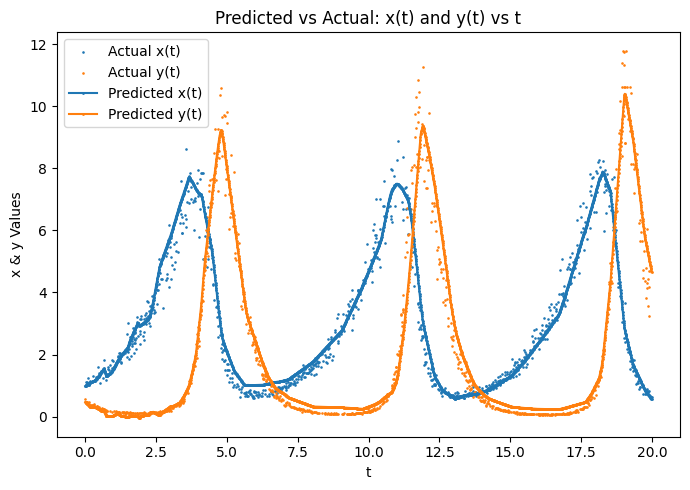

In [25]:
# Plot the actual and predicted x(t) and y(t) against t
plt.figure(figsize=(7, 5))

# Plot actual x(t) and y(t) from raw dataset against t
plt.scatter(my_df['t'], my_df['x'], label='Actual x(t)', marker='.', s=3)
plt.scatter(my_df['t'], my_df['y'], label='Actual y(t)', marker='.', s=3)

# Plot predicted x(t) and y(t) against t ** my_df['t'] same as t_values
plt.plot(t_values, predicted_x, label='Predicted x(t)', marker='.',markersize=2)
plt.plot(t_values, predicted_y, label='Predicted y(t)', marker='.',markersize=2)

# Add labels and title
plt.xlabel('t')
plt.ylabel('x & y Values')
plt.title('Predicted vs Actual: x(t) and y(t) vs t')
plt.legend()

# Adjust the layout for better display
plt.tight_layout()
plt.show()

# # Task : 2-2 Time-series extension

The simplified model above will only work well if $t\in[0,20]$.
Create a different model that can extrapolate `x,y` predictions to $t>20$.
Assume that the model has access to the same data as above, and is tasked to predict up to $t=100$. You can change anything in the above setup as needed, including model architecture, loss function, training procedure or data loader.

There are several different correct approaches to tackle this problem, all with different pros and cons, so make sure to explain your reasoning for the different choices made.


### Concept - ** for understanding only **
--> Task : Data Extrapolation (Extrapolation is the process of estimating an unknown value outside the range of the existing data. Like here we we train model when 0≤t≤20 but predict x(t) and y(t) when 0≤t≤100 meaning we predict on  20≤t≤100 which is unknown range)

### Data Pre-Processing
- Train model on same df_cleaned (327 data)
- Here for training , t = 0<t<20

In [246]:
# Create empty pandas df
df_new = df_cleaned

# Data Normalization, normalized feature 't'
t_min, t_max = df_new['t'].min(), df_new['t'].max()
df_new['t_norm'] = (df_new['t'] - t_min) / (t_max - t_min)

In [247]:
df_new.count()  # recheck

,0
t,327
x,327
y,327
t_norm,327


### Model: Fourier + MLP

#### Feature Extraction : Fourier Features

In [248]:
# Create Fourier Features for t
def fourier_features(t, max_k=5, T=1.0):
    t = np.array(t).reshape(-1, 1)
    features = [t]  # Polynomial features
    for k in range(1, max_k + 1):
        features.append(np.sin(k * np.pi * t / T))
        features.append(np.cos(k * np.pi * t / T))
    return np.concatenate(features, axis=1)

In [249]:
# x and y | tuned max_k == 1 to 10, max_k = 5 suits the best
X = fourier_features(df_new['t_norm'], max_k=5)  # Input features / Features / Independed-var
y = df_new[['x', 'y']].astype(float).values      # Output values / target-var / dependent-var

In [250]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

#### Model : MLP

In [251]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(

            # Input-Layer-1
            nn.Linear(input_dim, 128),
            nn.ReLU(),

            # Hidden-Layer-1
            nn.Linear(128, 256),
            nn.ReLU(),

            # Hidden-Layer-2
            nn.Linear(256, 64),
            nn.ReLU(),

            # Output-Layer
            nn.Linear(64, 2)  # Predicts x and y
        )

    def forward(self, x):
        return self.model(x)

#### Model Training

In [252]:
# Convert to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)

X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32)

# Initialize model
model = MLP(input_dim=X.shape[1]) # input_dim=X.shape[1] = 1 , 1 col/feature 't'
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-2)  # L2 regularization

In [253]:
# Training loop
epochs = 1001
for epoch in range(epochs):
    model.train() # sets the model in training mode, just optional

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    output = model(X_train_torch)
    loss = criterion(output, y_train_torch)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        model.eval()
        val_loss = criterion(model(X_val_torch), y_val_torch)
        print(f"Epoch {epoch} - Train Loss: {loss.item():.3f}, Val Loss: {val_loss.item():.3f}")


Epoch 0 - Train Loss: 12.336, Val Loss: 8.478
Epoch 100 - Train Loss: 0.116, Val Loss: 0.119
Epoch 200 - Train Loss: 0.112, Val Loss: 0.124
Epoch 300 - Train Loss: 0.112, Val Loss: 0.110
Epoch 400 - Train Loss: 0.108, Val Loss: 0.088
Epoch 500 - Train Loss: 0.136, Val Loss: 0.122
Epoch 600 - Train Loss: 0.106, Val Loss: 0.085
Epoch 700 - Train Loss: 0.107, Val Loss: 0.078
Epoch 800 - Train Loss: 0.108, Val Loss: 0.103
Epoch 900 - Train Loss: 0.109, Val Loss: 0.076
Epoch 1000 - Train Loss: 0.119, Val Loss: 0.131


### Model Predictions
- Extrapolate x,y when t is in [0, 100]

In [254]:
# Create extrapolation points
t_extrap = np.arange(0.01, 100.01, 0.01)  # from 0.01 to 100.00 inclusive, step=0.01

# Normalize t as during training
t_extrap_norm = (t_extrap - t_min) / (t_max - t_min) # t_min, t_max from before training, not t_extrap

# Create Fourier features
X_extrap = fourier_features(t_extrap_norm, max_k=5)           # max_k = 5 is best tuned
X_extrap_torch = torch.tensor(X_extrap, dtype=torch.float32)

# Predict
model.eval()
with torch.no_grad():
    y_pred = model(X_extrap_torch).numpy()

### Result

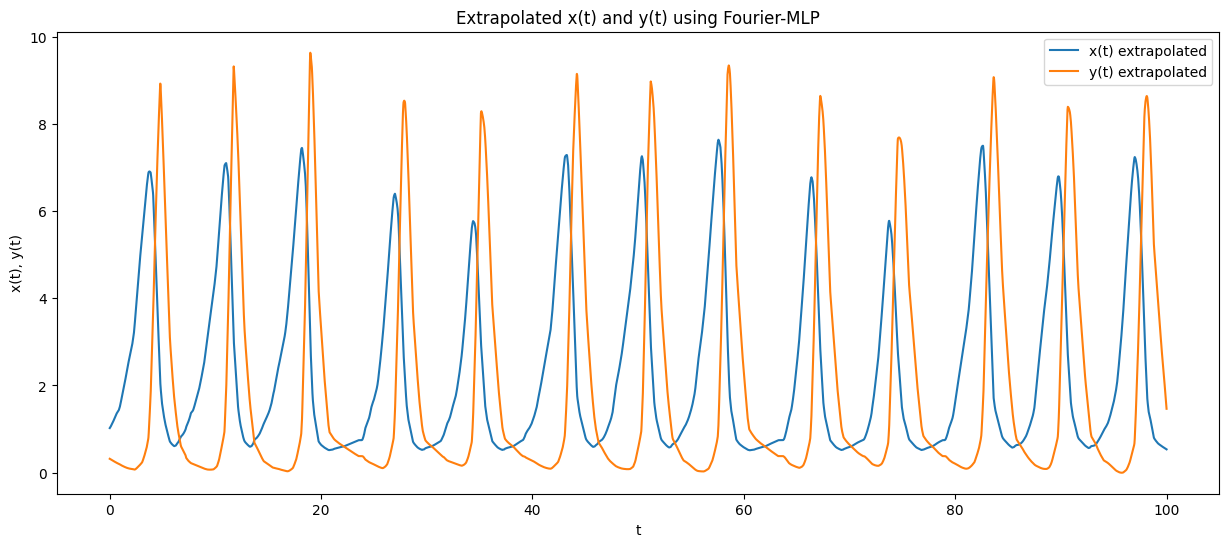

In [256]:
plt.figure(figsize=(15,6))

# Predicted / Extrapolated data plot
plt.plot(t_extrap, y_pred[:, 0], label='x(t) extrapolated')
plt.plot(t_extrap, y_pred[:, 1], label='y(t) extrapolated')

# # Actual data plot - for testing | dots in the plot from 0<t<20 are the actual vals
# plt.scatter(df_new['t'], df_new['x'], marker='.', color='blue', s=7, label='x (train)', alpha=0.3)
# plt.scatter(df_new['t'], df_new['y'], marker='.', color='orange', s=7, label='y (train)', alpha=0.3)

plt.legend()
plt.xlabel("t")
plt.ylabel("x(t), y(t)")
plt.title("Extrapolated x(t) and y(t) using Fourier-MLP")
plt.show()


### Reason i Chose Fourier + MLP Approach :-

***Why did I choose "Fourier + MLP" approach ?***
- There are Different approaches :-
  - Fourier Features + MLP
  - RNN/LSTM
  - Neural ODEs / Continuous Time Models
  - Time Series Transformer models

→ These are a few of the many approaches that can be used to solve this assignment. All have their own advantages and disadvantages based on specific dataset and use cases.  I have chosen  **(1) Fourier Features + MLP**  for solving this task part 2-2 (Time Series Extension).

<br>

---

<br>

**Fourier Features + MLP :** The idea here is to expand scalar ‘t’ using sinusoidal and polynomial features before feeding into the Neural Network MLP() . Here, the Fourier series is used as a feature extractor to extract specific features or learn specific patterns of the data.

→ Reasons for choosing :-
1. **Smaller & Simpler Dataset :-** <br> The dataset is a bivariate time series dataset that has only one feature ‘t’ and two target vars x & y. Meaning, the data is 1D-Time Series (function of t), predicting continuous variables x(t), y(t) based solely on t. There’s no sequential dependency (no past x(t-1) needed to predict x(t)).  Also, the data feature ‘t’ values goes from t = 0 to 20 in very small intervals 0.01 and has about 2000 sample points. Moreover, much of the data are corrupted or missing, hence after cleaning there are only 327 data samples. This dataset is too small & too simple for complex deep learning models like Transformers or RNN/LSTMs, etc., to generalize without overfitting. Therefore, complex sequence models like LSTM, RNN, or Transformer are overkill and extremely complicated for this application & dataset.  The Fourier + MLP combination works great with smaller, clean, smooth datasets like this one.  That is a significant reason that the best option for this dataset for extrapolation is ***Fourier + MLP*** approach.

2. **Extremely Easy to Implement :-**  <br> This process has No padding/masking like in RNN/Transformer, No numerical solvers like Neural ODE. Hence this implementation of fourier features is extremely easy as it can be see in **fourier_features()** function. The MLP() is typical pytorch deep network implementation.

3. **Faster System:-**  <br> This approach has both Faster Training & Faster Inference / predictions than RNN/LSTM , Transformers and Neural ODEs.

4. **Data Extrapolation Applications :-**  <br> MLP + Fourier is a comparatively easy and better  approach for data extrapolation use cases than RNN/LSTM or even transformers. It Helps MLP to easily generalize x,y beyond training range (t > 20).

5. **Control Generalization Easily :-**  <br> It is possible to tune max_k, to control frequency capacity (too high = overfit). I tested "1 < max_k < 10" and found max_k=5 is the best fitted. Can add Normalized t-values for better generalization. This level of direct control is not available in complex models like LSTMs etc.

6. **Periodic Components :-** <br> This dataset has periodic components as it repeats similar pattern after particular time. Also an interval of 0.01 in t-values. Fourier approach captures periodic trends, even in small datasets.


7. **Fourier Controls the growing Drift of x, y with t :-**  <br> During my experimentations, I found that the x,y values kept growing by a lot, with t values after a certain t.  This was a huge problem, but solved easily as I used fourier.  One of the key advantages of using Fourier features is the flexibility to include or exclude polynomial terms such as t2,t3 etc., based on the behavior of the output. <br>
In my initial setup, combining polynomial features with Fourier terms led to a growing drift in the predicted x and y values over time, especially during extrapolation t>20. This happened because higher degree polynomial terms tend to grow unbounded as t increases, causing the model to output excessively large values. By removing all polynomial components and retaining only the bounded sinusoidal Fourier terms (i.e., sine and cosine), i was able to stabilize the predictions and prevent the model from diverging at higher t. This highlights a valuable property of the Fourier-based feature encoding: it enables controlled and smooth extrapolation by eliminating unbounded growth, which is particularly beneficial for time-series modeling tasks.

Therefore, Based on the above analysis, I concluded that this approach offers the best trade-off among the different models evaluated.
